# Toolbox para modelos de Machine Learning

En este notebook vamos a explicar el uso y la utilidad de las funciones incluidas en nuestra "pequeña librería" `toolbox_ML.py`. Para ello, las aplicaremos al caso de uso que más familiar nos resulta, en este caso, el dataset del titanic. Iremos ejecutando cada una de las funciones y explicando lo que hacen y para qué pueden servirnos. También, por supuesto, iremos descubriendo nuevas necesidades a medida que ahondamos más en este nuevo bloque de contenido, por lo que podremos tanto añadir funciones nuevas como completar y afinar las que ya tenemos.

In [2]:
# Importamos todo lo necesario
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import toolbox_ML as tb

# Cargamos el dataset
df_titanic = pd.read_csv("./data/titanic.csv")
display(df_titanic)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


## 1. `describe_df`
Uno de los primeros pasos a la hora de modelar cualquier algoritmo es, simple y llanamente, conocer bien los datos con los que estamos tratando. Esto requiere, por supuesto, un primer vistazo e investigación a nivel cualitativo, pero ya nos hemos dado cuenta que es igual de importante un análisis cuantitativo, para saber qué limpiar, en que variables centrarnos, tipificar más adelante... Es por eso que creamos esta primera función, la cual básicamente toma un dataset de entrada (que, en este caso, será el del titanic como hemos comentado), y devuelve otro dataframe que recoge información relevante de cada una de las columnas:

- DATA_TYPE: El tipo de dato (en python) de cada variable.
- MISSINGS (%): El porcentaje de nulos/missings.
- UNIQUE_VALUES: El número de valores únicos de cada columna.
- CARDIN (%): La cardinalidad de cada variable.

Todo esto nos ayudará a encarrilar y dar el primer empujón a nuestro análisis.

In [3]:
tb.describe_df(df_titanic)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
DATA_TYPE,int64,int64,object,float64,int64,int64,float64,object,object,object,bool,object,object,object,bool
MISSINGS (%),0.0,0.0,0.0,19.86532,0.0,0.0,0.0,0.224467,0.0,0.0,0.0,77.216611,0.224467,0.0,0.0
UNIQUE_VALUES,2,3,2,88,7,7,248,3,3,3,2,7,3,2,2
CARDIN (%),0.22,0.34,0.22,9.88,0.79,0.79,27.83,0.34,0.34,0.34,0.22,0.79,0.34,0.22,0.22


## 2. `tipifica_variables`
Una vez que hemos hecho ese primer barrido del que hablabámos, tanto a nivel cualitativo como cuantitativo, tenemos que empezar a centrar las cosas. Ya sabemos que el tratamiento que se le da a las variables es muy distinto dependiendo precisamente del tipo de variable con el que trabajemos. Es por ello que surge la necesidad de crear esta función que, en un paso, tipifica todas las variables de nuestro dataframe. 

Para ello hemos usado el criterio al que ya estamos acostumbrados, la cardinalidad, acompañado de unos umbrales que, aunque podrán elegirse dependiendo del criterio, hemos dejado establecidos por defecto como 10, en el caso del número máximo de categorías y un 20% de cardinalidad para considerar una variable numérica como continua. Teniendo esto claro, clasificamos de la siguiente manera: 
- Si una variable tiene exactamente dos valores únicos, se clasifica como "Binaria".
- Si el número de valores únicos es menor que `umbral_categoria`, se clasifica como "Categorica".
- Si el numero de valores unicos es mayor o igual que `umbral_categoria`:
    * Si la cardinalidad es mayor o igual que `umbral_continua`, se clasifica como "Numerica Continua".
    * Si no (cardinalidad menor que `umbral_continua`), se clasifica como "Numerica Discreta".

In [4]:
tb.tipifica_variables(df_titanic)

,nombre_variable,tipo_sugerido
0,survived,Binaria
1,pclass,Categorica
2,sex,Binaria
3,age,Numerica Discreta
4,sibsp,Categorica
5,parch,Categorica
6,fare,Numerica Continua
7,embarked,Categorica
8,class,Categorica
9,who,Categorica


## 3. `get_features_num_regression`

Esta función recibe como argumentos un dataframe, el nombre de la variable objetivo de un modelo de regresión (target_col) y un umbral de correlación (umbral_corr), que debe ser un valor entre 0 y 1. Además, incluye un argumento opcional llamado pvalue, que en esta versión no se utiliza, aunque se mantiene por compatibilidad.


El propósito de la función es identificar y devolver aquellas variables numéricas del dataframe cuya correlación con la variable objetivo sea suficientemente alta, según el umbral indicado. Para ello, se utiliza la matriz de correlación de pandas, evaluando la fuerza de la relación lineal entre las variables.


Como parte de su funcionamiento, la función incorpora comprobaciones para asegurar que los argumentos proporcionados sean válidos (por ejemplo, que la variable objetivo exista en el dataframe y sea de tipo numérico). También emite mensajes de advertencia o error cuando es necesario.


In [5]:
columnas_correlacionadas = tb.get_features_num_regression(
    df=df_titanic,
    target_col='pclass',
    umbral_corr=0.2
)


print("Columnas numéricas correlacionadas con 'pclass':")
print(columnas_correlacionadas)

Columnas numéricas correlacionadas con 'pclass':
['survived', 'age', 'fare']


In [9]:
columnas_correlacionadas = tb.get_features_num_regression(
    df=df_titanic,
    target_col='age',
    umbral_corr=0.2
)


print("Columnas numéricas correlacionadas con 'age':")
print(columnas_correlacionadas)

Columnas numéricas correlacionadas con 'age':
['pclass', 'sibsp']


In [10]:
columnas_correlacionadas = tb.get_features_num_regression(
    df=df_titanic,
    target_col='fare',
    umbral_corr=0.2
)


# Mostrar resultado
print("Columnas numéricas correlacionadas con 'fare':")
print(columnas_correlacionadas)

Columnas numéricas correlacionadas con 'fare':
['survived', 'pclass', 'parch']


## 4. `plot_features_num_regression`

Esta función tiene como objetivo generar visualizaciones tipo pairplot que permitan explorar gráficamente la relación entre una variable objetivo (target_col) y otras variables numéricas del dataset. Para ello, selecciona únicamente aquellas columnas cuya correlación con la variable objetivo sea suficientemente alta, según un umbral especificado (umbral_corr). Además, opcionalmente, puede filtrar las columnas que resulten estadísticamente significativas mediante un test de Pearson, si se indica un valor para el argumento pvalue.


El usuario puede proporcionar una lista específica de columnas numéricas a evaluar, o bien dejar que la función seleccione todas las numéricas automáticamente (excluyendo la variable objetivo). Las visualizaciones se organizan en grupos de hasta cinco variables (incluyendo siempre la variable target) para evitar sobrecargar los gráficos.


La función incluye comprobaciones básicas para validar la entrada y garantizar un funcionamiento robusto, mostrando mensajes de error o advertencia cuando es necesario. Finalmente, devuelve la lista de columnas que cumplen con los criterios establecidos.


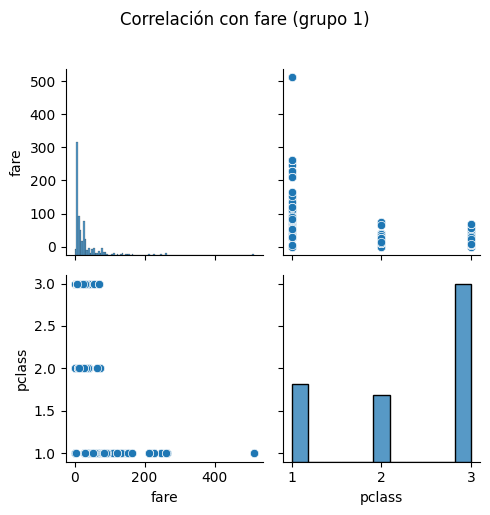

Columnas filtradas que se han visualizado:
['pclass']


In [11]:
columnas_usadas = tb.plot_features_num_regression(
    df=df_titanic,
    target_col='fare',
    columns=[],        
    umbral_corr=0.3,
    pvalue=None
)


print("Columnas filtradas que se han visualizado:")
print(columnas_usadas)

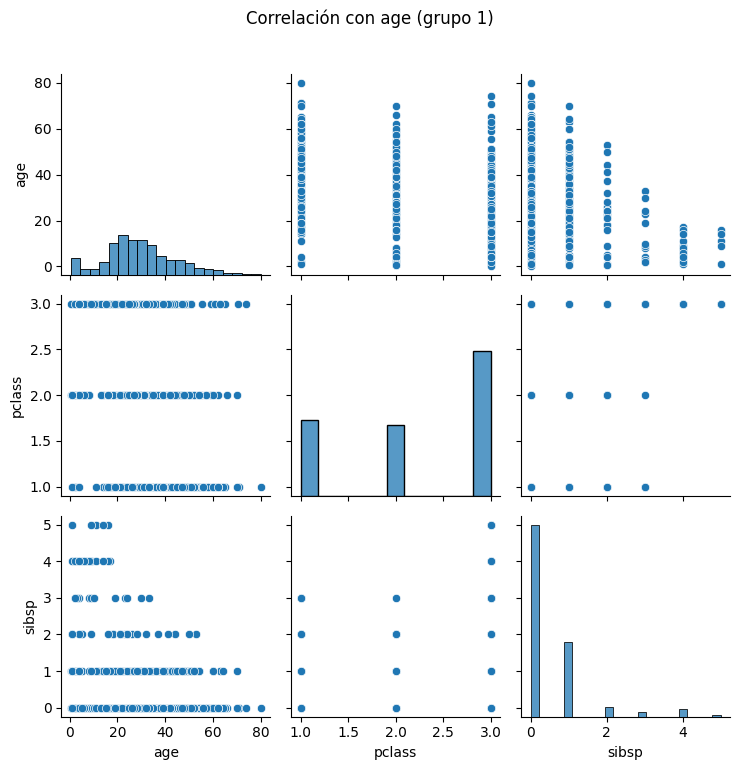

Columnas filtradas que se han visualizado:
['pclass', 'sibsp']


In [12]:
columnas_usadas = tb.plot_features_num_regression(
    df=df_titanic,
    target_col='age',
    columns=[],        
    umbral_corr=0.3,
    pvalue=None
)


print("Columnas filtradas que se han visualizado:")
print(columnas_usadas)

In [ ]:
columnas_usadas = tb.plot_features_num_regression(
    df=df_titanic,
    target_col='pclass',
    columns=[],        
    umbral_corr=0.3,
    pvalue=None
)


print("Columnas filtradas que se han visualizado:")
print(columnas_usadas)

## 5. `get_features_cat_regression`
Esta función recibe como argumentos un `dataframe` y el nombre de una de las columnas del mismo (argumento `target_col`), que debería corresponder al target de un hipotético modelo de regresión. Es decir, debe tratarse de una variable numérica, ya sea continua o discreta, pero con una alta cardinalidad. Además, se incluye la variable `pvalue`, cuyo valor por defecto se ha fijado en 0.05.

El objetivo de esta función es devolver una lista con aquellas columnas categóricas del dataframe cuya relación con la variable indicada en 'target_col' sea estadísticamente significativa. Para ello, la función debe ser capaz de identificar qué tipo de test es el adecuado en cada caso.

Como parte de su funcionamiento, la función incorpora una serie de comprobaciones destinadas a evitar errores derivados de entradas no válidas. 

In [6]:
tb.get_features_cat_regression(df_titanic, "age")

['sex', 'class', 'who', 'deck', 'alive']

## 6. `plot_features_regression`
Esta función recibe un `dataframe`, un argumento `target_col` con valor por defecto "", una `lista` de strings columns cuyo valor por defecto es la lista vacía, un argumento `pvalue` con valor 0.05 por defecto y un argumento `with_individual_plot` que, por defecto, es False.

Lo primero que hace la función es comprobar los valores de entrada. A partir de ahí, el comportamiento de la función dependerá de si la lista columns está vacía o no.

Si la lista no está vacía, la función evaluará cada una de las variables categóricas contenidas en ella. Para aquellas cuya relación con la variable target_col resulte estadísticamente significativa al nivel 1−pvalue, se generarán histogramas agrupados según el valor de la variable objetivo. La función devolverá únicamente las variables que cumplan esta condición.

Si la lista está vacía, se considerará que el análisis debe realizarse sobre las variables numéricas del dataframe. En ese caso, columns se igualará a dichas variables y el funcionamiento continuará según lo descrito en el apartado anterior.

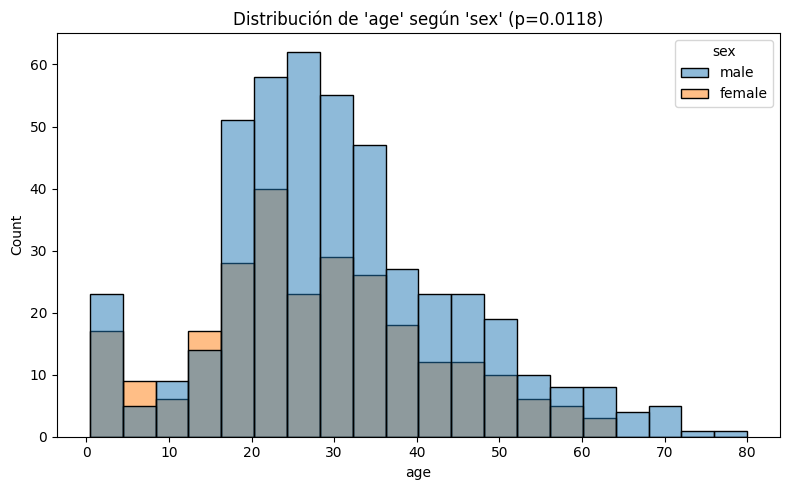

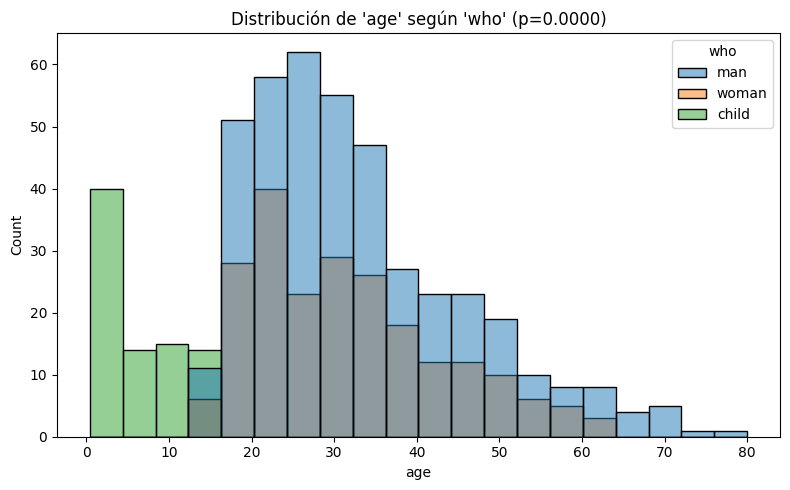

['sex', 'who']

In [7]:
tb.plot_features_regression(df_titanic, target_col="age", columns=["sex", "who"], pvalue=0.05, with_individual_plot=True)

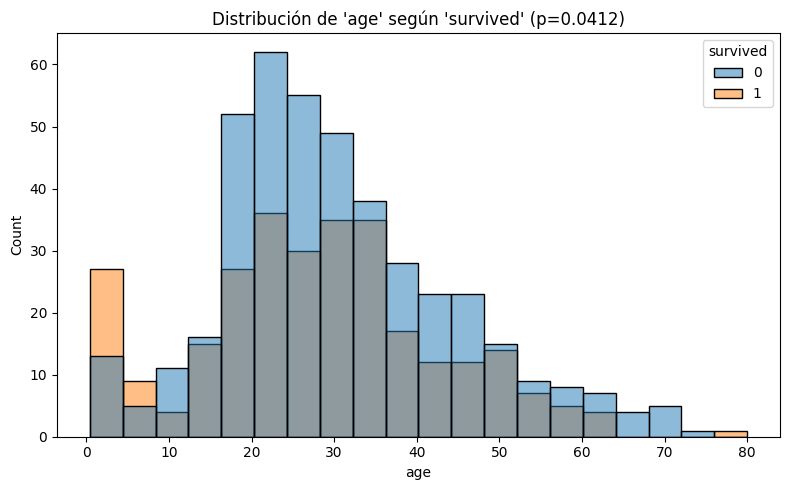

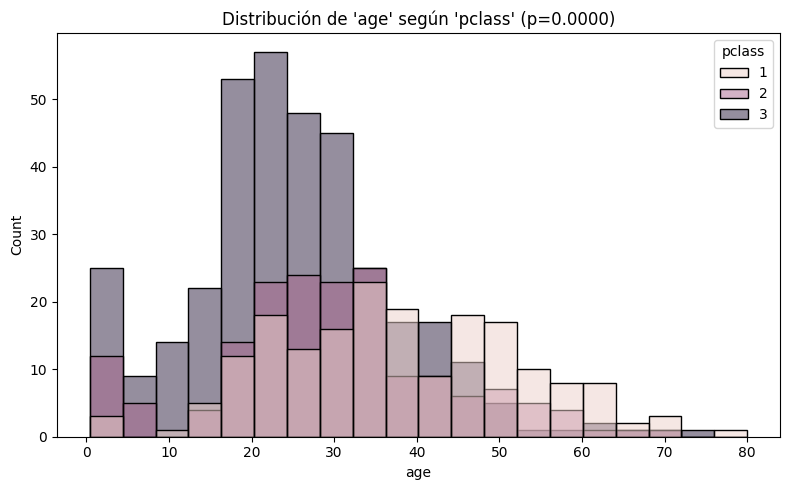

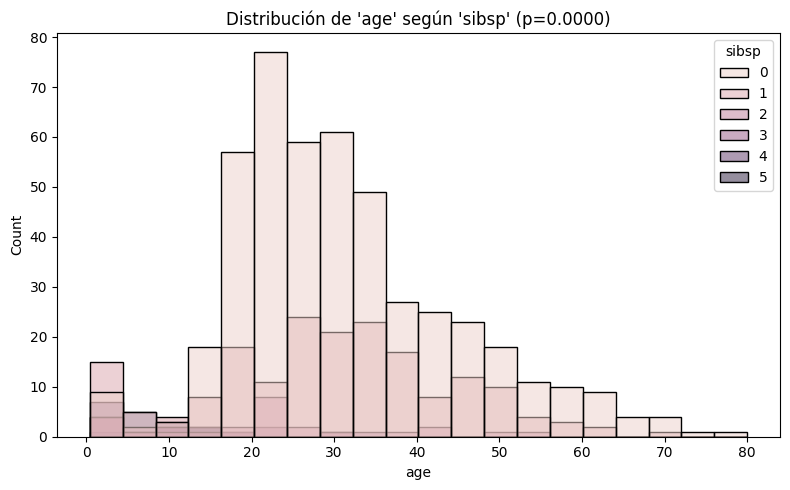

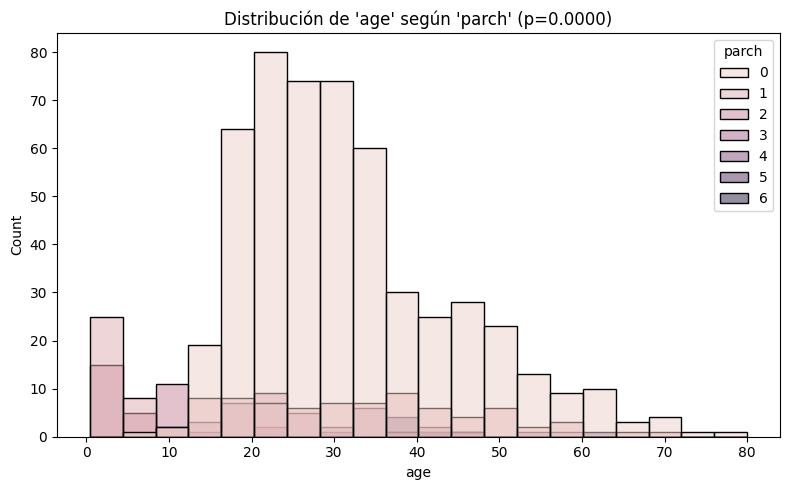

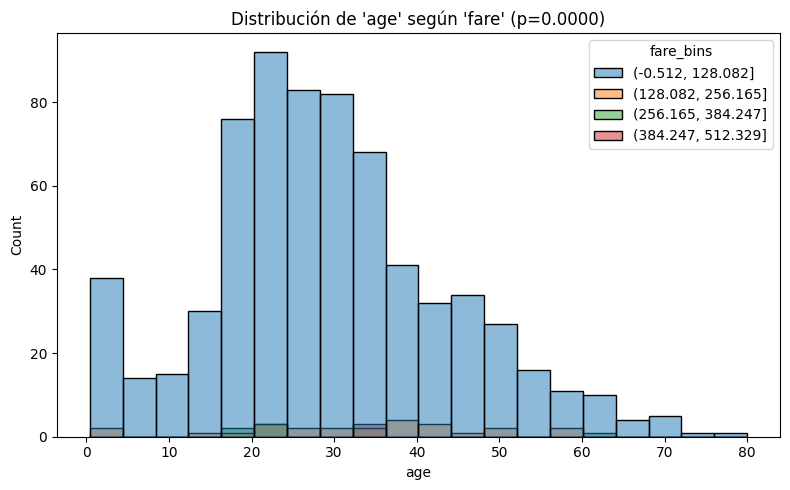

['survived', 'pclass', 'sibsp', 'parch', 'fare']

In [8]:
tb.plot_features_regression(df_titanic, target_col="age", columns=[], pvalue=0.05, with_individual_plot=True)